# Load Configuration Data

In [2]:
import json
import os

# Check if the file exists and load the JSON file into a dictionary
file_path = r'C:\Users\mike\Develop\Projects\Code Notebook\Credentials\locations_conf.json'
if os.path.exists(file_path):
    with open(file_path, 'r') as f:
        locations_data = json.load(f)
    print(locations_data)
else:
    print(f"File not found: {file_path}")

{'Common_Funcs_Dir': '/Users/mike/Develop/Projects/Code Notebook/Common/Functions', 'Credentials_Dir': '/Users/mike/Develop/Projects/Code Notebook/Credentials', 'Rel_Pickes_Dir': '../.pickles', 'Pub_Data_Dir': "'/Users/mike/Data/Public", 'BQ_Service_Key': '/Users/mike/Develop/Conf/GCP Service Keys/mikecancell-development-0bcca41f8486.json'}


# Load the DF by Querying Banking Data

In [3]:
from google.oauth2 import service_account
import pandas_gbq

# Ensure locations_data is defined
if 'locations_data' not in globals():
	# Check if the file exists and load the JSON file into a dictionary
	if os.path.exists(file_path):
		with open(file_path, 'r') as f:
			locations_data = json.load(f)
	else:
		raise FileNotFoundError(f"File not found: {file_path}")

# Resolve the key path from the locations data
key_path = locations_data.get('BQ_Service_Key', 'default_key_path.json')

# Create credentials using the key file
credentials = service_account.Credentials.from_service_account_file(key_path)

# Define your project ID and the SQL query
project_id = 'mikecancell-development'
query = """
SELECT *
FROM `mikecancell-development.Datasets.Banking_Data`
"""

# Read the data from BigQuery into a pandas DataFrame
bank_data = pandas_gbq.read_gbq(query, project_id=project_id, credentials=credentials)

# Display the first few rows of the dataframe
print(bank_data.head())

Downloading: 100%|██████████|
      Attrition_Flag  Age Gender  Dependent_count Education_Level  \
0  Existing Customer   47      M                4     High School   
1  Existing Customer   62      F                1         Unknown   
2  Existing Customer   60      F                0     High School   
3  Existing Customer   65      M                0        Graduate   
4  Existing Customer   38      M                1        Graduate   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $40K - $60K          Blue              42   
1        Married  Less than $40K          Blue              56   
2        Married  Less than $40K          Blue              50   
3         Single     $40K - $60K          Blue              36   
4         Single    $80K - $120K          Blue              25   

   Total_Relationship_Count  ...  is_Attrited   Age_Group  \
0                         6  ...        False  Age: 45-54   
1                         6  ...    

# Analysis

```markdown
# Outline for Analyzing Bank Data: Drivers of Attrition

## 1. Data Overview
- **Objective**: Identify key drivers of customer attrition by comparing attritted vs existing customers.
- **Dataset Summary**:
    - Total rows: 10,127
    - Key columns: `Attrition_Flag`, `Age`, `Gender`, `Dependent_count`, `Education_Level`, `Income_Category`, `Credit_Limit`, `Total_Trans_Amt`, etc.

## 2. Data Cleaning and Preparation
- Check for missing or null values in critical columns.
- Ensure data types are consistent (e.g., numeric columns for analysis).
- Remove or impute missing values if necessary.

## 3. Exploratory Data Analysis (EDA)
### 3.1 Demographic Analysis
- Compare `Age`, `Gender`, `Education_Level`, and `Marital_Status` distributions between attritted and existing customers.
- Group `Age` into bins (e.g., 18-25, 26-35, etc.) for better visualization.

### 3.2 Financial Behavior
- Analyze `Income_Category`, `Credit_Limit`, and `Avg_Utilization_Ratio` for both groups.
- Identify trends in spending behavior using `Total_Trans_Amt` and `Total_Trans_Ct`.

### 3.3 Account Activity
- Compare `Months_on_book`, `Total_Relationship_Count`, and `Months_Inactive_12_mon`.
- Analyze `Contacts_Count_12_mon` to understand engagement levels.

## 4. Feature Engineering
- Create new features such as:
    - `Credit_Utilization` = `Total_Revolving_Bal` / `Credit_Limit`
    - `Engagement_Score` = `Total_Trans_Ct` / `Months_on_book`
- Group categorical variables into meaningful bins (e.g., `Income_Category`, `Credit_Limit_Group`).

## 5. Statistical Analysis
- Perform hypothesis testing (e.g., t-tests, chi-square tests) to identify significant differences between attritted and existing customers.
- Correlation analysis to find relationships between features and attrition.

## 6. Predictive Modeling
- Build a classification model to predict attrition:
    - Split data into training and testing sets.
    - Use models like Logistic Regression, Random Forest, or Gradient Boosting.
    - Evaluate model performance using metrics like accuracy, precision, recall, and F1-score.

## 7. Insights and Recommendations
- Summarize key findings from the analysis.
- Provide actionable recommendations to reduce attrition, such as:
    - Targeted engagement strategies for high-risk customers.
    - Incentives for customers with low transaction activity.
    - Personalized offers based on financial behavior.

## 8. Visualization
- Use visualizations to support findings:
    - Bar charts for categorical comparisons.
    - Box plots for numerical distributions.
    - Heatmaps for correlation analysis.

## 9. Conclusion
- Recap the main drivers of attrition.
- Highlight next steps for further analysis or business actions.
```

## 1. Data Overview
- **Objective**: Identify key drivers of customer attrition by comparing attritted vs existing customers.
- **Dataset Summary**:
    - Total rows: 10,127
    - Key columns: `Attrition_Flag`, `Age`, `Gender`, `Dependent_count`, `Education_Level`, `Income_Category`, `Credit_Limit`, `Total_Trans_Amt`, etc.

Age: t-statistic = 1.90, p-value = 0.0577
Dependent_count: t-statistic = 1.94, p-value = 0.0525
Credit_Limit: t-statistic = -2.40, p-value = 0.0164
Total_Trans_Amt: t-statistic = -22.69, p-value = 0.0000
Total_Trans_Ct: t-statistic = -54.14, p-value = 0.0000
Avg_Utilization_Ratio: t-statistic = -18.62, p-value = 0.0000
Gender: chi2 = 13.87, p-value = 0.0002
Education_Level: chi2 = 12.51, p-value = 0.0515
Marital_Status: chi2 = 6.06, p-value = 0.1089
Income_Category: chi2 = 12.83, p-value = 0.0250


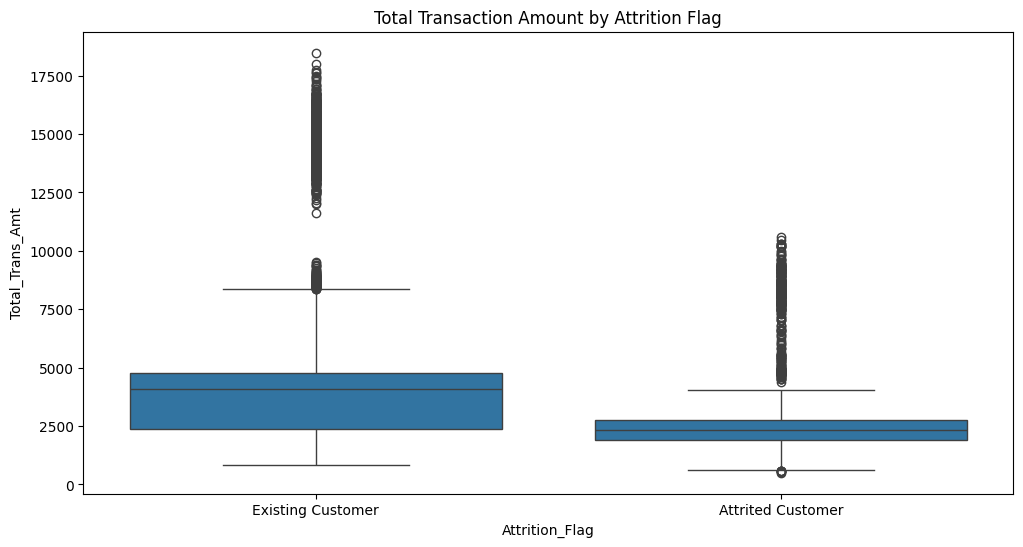

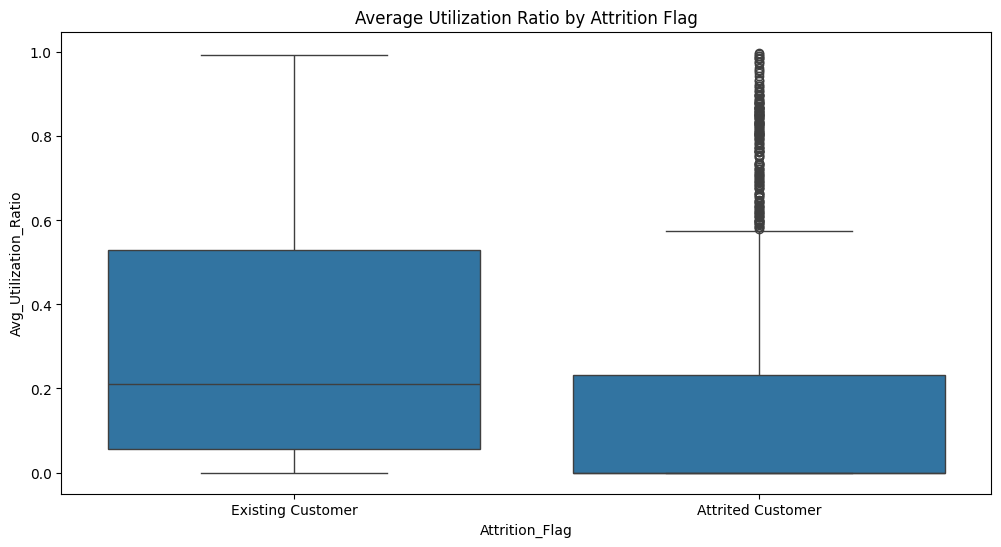

In [5]:
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

import matplotlib.pyplot as plt

# Separate attrited and non-attrited clients
attrited = bank_data[bank_data['Attrition_Flag'] == 'Attrited Customer']
non_attrited = bank_data[bank_data['Attrition_Flag'] == 'Existing Customer']

# Numerical features to analyze
numerical_features = ['Age', 'Dependent_count', 'Credit_Limit', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Avg_Utilization_Ratio']

# Perform t-tests for numerical features
for feature in numerical_features:
    t_stat, p_val = ttest_ind(attrited[feature], non_attrited[feature], equal_var=False)
    print(f"{feature}: t-statistic = {t_stat:.2f}, p-value = {p_val:.4f}")

# Categorical features to analyze
categorical_features = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category']

# Perform chi-square tests for categorical features
for feature in categorical_features:
    contingency_table = pd.crosstab(bank_data[feature], bank_data['Attrition_Flag'])
    chi2, p_val, _, _ = chi2_contingency(contingency_table)
    print(f"{feature}: chi2 = {chi2:.2f}, p-value = {p_val:.4f}")

# Visualize key differences
plt.figure(figsize=(12, 6))
sns.boxplot(x='Attrition_Flag', y='Total_Trans_Amt', data=bank_data)
plt.title('Total Transaction Amount by Attrition Flag')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Attrition_Flag', y='Avg_Utilization_Ratio', data=bank_data)
plt.title('Average Utilization Ratio by Attrition Flag')
plt.show()

## 2. Data Cleaning and Preparation
- Check for missing or null values in critical columns.
- Ensure data types are consistent (e.g., numeric columns for analysis).
- Remove or impute missing values if necessary.

In [7]:
# Handle missing values (if any)
# For demonstration, we will fill numeric columns with their mean and categorical columns with 'Unknown'
for col in critical_columns:
    if bank_data[col].dtype in ['float64', 'int64', 'Int64']:
        bank_data[col] = bank_data[col].fillna(bank_data[col].mean())
    elif bank_data[col].dtype == 'object':
        bank_data[col] = bank_data[col].fillna('Unknown')

# Verify that there are no missing values after imputation
print("\nMissing values after handling:")
print(bank_data[critical_columns].isnull().sum())



Missing values after handling:
Attrition_Flag           0
Age                      0
Gender                   0
Dependent_count          0
Education_Level          0
Income_Category          0
Credit_Limit             0
Total_Trans_Amt          0
Total_Trans_Ct           0
Avg_Utilization_Ratio    0
dtype: int64
